In [2]:
#import libraries
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import scipy as scipy
import csv
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
#Sigmoid function (input might be scalar or vector)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
lemma = nltk.wordnet.WordNetLemmatizer()
tfidf = TfidfVectorizer()
lambdas = np.logspace(-4,np.log10(0.5),num=50,endpoint = True,base =10)

#reading CSV to get train and test data
with open("train.csv","r") as csvfile:
    traindata = csv.reader(csvfile, delimiter=',')
    traindata = list(traindata)
    traindata = traindata[1:]
	
with open("test.csv","r") as csvfile:
    testdata = csv.reader(csvfile, delimiter=',')
    testdata = list(testdata)
    testdata = testdata[1:]
    
#merge train and test data
data = np.concatenate((traindata, testdata),axis=0)
print("length of concatanated train and test data:", len(data))

length of concatanated train and test data: 5572


In [4]:
texts = []
labels = []
Ydata = []
for i in range(len(data)):
    labels.append(data[i][0])
    texts.append(data[i][1])
    lemma.lemmatize(texts[i]) #lemmatization

#label Y data
for i in range(len(data)):
    if labels[i] == "spam":
        Ydata.append(1)
    else:
        labels[i] == "ham"
        Ydata.append(0)

#separate train and test Y data
Ytrain = Ydata[0:len(traindata)]
Ytrain = np.transpose(np.matrix((Ytrain)))
#Ytrain = np.concatenate((np.matrix([0]), Ytrain), axis=0) #Include bias term in Ytrain
Ytest =	Ydata[len(traindata)+1:]
Ytest = np.transpose(np.matrix((Ytest)))
print("Number of training data:", len(Ytrain))
print("Number of test data:", len(Ytest))

Number of training data: 3000
Number of test data: 2571


In [5]:
#get TF_IDF of data
tfs_sparse = tfidf.fit_transform(texts)
#print(tfs_sparse)

#separate train and test X data
tfs_train = tfs_sparse[0:len(traindata),:]
tfs_test = tfs_sparse[len(traindata)+1:,:]

tfs = tfs_train
#create array with random index numbers
randind = np.arange(tfs.toarray().shape[0])
np.random.shuffle((randind))

print("shape of tfidf train matrix:", np.shape(tfs_train))
print("shape of tfidf test matrix:",np.shape(tfs_test))

shape of tfidf train matrix: (3000, 8761)
shape of tfidf test matrix: (2571, 8761)


In [7]:
#shuffle data
xshuffled = tfs[randind,:]
yshuffled = Ytrain[randind,:]

#splitting data
split = int(xshuffled.shape[0]/10)
lambdalossesvalidation = np.zeros((10,len(lambdas)))
lambdalossestrain = np.zeros((10,len(lambdas)))
optindex = np.zeros((10,1))
lossvalidationavg = np.zeros((10,1))
print("length of validation set:", split)

length of validation set: 300


In [45]:
#Cross Validation
for i in range(10):

	#select foldwise train and validation X, Y data
	cvtestx = xshuffled[split*i:split+(split*i),:]
	cvtestxtrans = np.transpose(cvtestx)
	cvtestx = scipy.sparse.csr_matrix(cvtestx) #convert to sparse matrix
	cvtestxtrans = scipy.sparse.csr_matrix(cvtestxtrans)
	cvtrainx = np.delete(xshuffled.toarray(),[x for x in range(split*i,split+(split*i))],0)
	cvtrainxtrans = np.transpose(cvtrainx)
	cvtrainx = scipy.sparse.csr_matrix(cvtrainx) #convert to sparse matrix
	cvtrainxtrans = scipy.sparse.csr_matrix(cvtrainxtrans)
	cvtesty = yshuffled[split*i:split+(split*i)]
	cvtesty = scipy.sparse.csr_matrix(cvtesty) #convert to sparse matrix
	cvtrainy = np.delete(yshuffled,[x for x in range(split*i,split+(split*i))],0)
	cvtrainytrans = np.transpose(cvtrainy)
	cvtrainy = scipy.sparse.csr_matrix(cvtrainy) #convert to sparse matrix
	cvtrainytrans = scipy.sparse.csr_matrix(cvtrainytrans) #convert to sparse matrix
	minlossvalidation = 1000000
     
	for j in range(len(lambdas)):
		cvweights = np.zeros((tfs.shape[1],1)) #initialize to zero the weight vector that gets updated with iterations
		gradient = np.ones((1,tfs.shape[1]))
		iters, diff = 1, 1
		gradientprev = 1000000;
		while ((diff > 0.0025) and iters < 5000): #precision and maximum iterations (to avoid infinite loop)
			gradient = np.zeros((1,tfs.shape[1]))
			iters += 1
			gradient = np.transpose((sigmoid((cvtrainx*cvweights))-cvtrainy)) * cvtrainx #compute gradient
			diff = (np.linalg.norm(gradient,ord = 1)-gradientprev)/(-gradientprev) #compute difference
			gradientprev = np.linalg.norm(gradient,ord = 1) #save gradient
			cvweights = cvweights - (2.25*(iters**(-0.9)))*(np.transpose(gradient) + lambdas[j]*cvweights) #update weights
		
		#compute validation and train losses (normalized)
		lossvalidation = ((np.transpose(cvtesty)*(-cvtestx*cvweights))+np.sum((np.log(1+np.exp(cvtestx*cvweights)))))/cvtesty.shape[0]
		losstrain = ((np.transpose(cvtrainy)*(-cvtrainx*cvweights))+np.sum((np.log(1+np.exp(cvtrainx*cvweights)))))/cvtrainy.shape[0]
		
		#save validation and train losses
		lambdalossesvalidation[i,j] = lossvalidation
		lambdalossestrain[i,j] = losstrain
		if minlossvalidation > lossvalidation:
			minlossvalidation = lossvalidation
			optindex[i] = j #save index with lowest loss among lambdas
		lossvalidationavg[i] = lossvalidationavg[i] + lossvalidation #sum up lambda losses 
	print("FOLD", i+1,"(Optimal lossvalidation, lambda): ", lambdalossesvalidation[i,int(optindex[i])], lambdas[int(optindex[i])])
	lossvalidationavg[i] = lossvalidationavg[i]/len(lambdas) #compute validation loss average
	print("Avg. lossvalidation: ", lossvalidationavg[i])

FOLD 1 (Optimal lossvalidation, lambda):  0.0667755220916 0.03098439811
Avg. lossvalidation:  [ 0.07707842]
FOLD 2 (Optimal lossvalidation, lambda):  0.108478002787 0.0621011723927
Avg. lossvalidation:  [ 0.12866708]
FOLD 3 (Optimal lossvalidation, lambda):  0.112892074153 0.10460859051
Avg. lossvalidation:  [ 0.15597036]
FOLD 4 (Optimal lossvalidation, lambda):  0.103251972019 0.0438653331062
Avg. lossvalidation:  [ 0.13996113]
FOLD 5 (Optimal lossvalidation, lambda):  0.0668378101526 0.0260407735158
Avg. lossvalidation:  [ 0.07667036]
FOLD 6 (Optimal lossvalidation, lambda):  0.0707621476806 0.03098439811
Avg. lossvalidation:  [ 0.0841245]
FOLD 7 (Optimal lossvalidation, lambda):  0.110921085816 0.0521928023131
Avg. lossvalidation:  [ 0.13560553]
FOLD 8 (Optimal lossvalidation, lambda):  0.16348650118 0.10460859051
Avg. lossvalidation:  [ 0.24943489]
FOLD 9 (Optimal lossvalidation, lambda):  0.0902556209582 0.0368665287787
Avg. lossvalidation:  [ 0.10629395]
FOLD 10 (Optimal lossvali

In [46]:
bestfold = np.argmin(lossvalidationavg) #select best fold index
bestlambda = lambdas[int(optindex[bestfold])] #select best lambda from best fold
lowestloss = lambdalossesvalidation[bestfold,int(optindex[bestfold])] #select lowest validation loss from best fold
bestvalidationlosses = lambdalossesvalidation[bestfold,:] #best fold validation losses
besttrainlosses = lambdalossestrain[bestfold,:] #best fold train

#Allocate memory
minvalidationlosses = np.zeros((len(lambdas)))
maxvalidationlosses = np.zeros((len(lambdas)))
avgvalidationlosses = np.zeros((len(lambdas)))

#compute min, max and avg losses among folds, per lambda
for i in range(len(lambdas)):
	minvalidationlosses[i] = np.amin(lambdalossesvalidation[:,i],axis=0)
	maxvalidationlosses[i] = np.amax(lambdalossesvalidation[:,i],axis=0)
	avgvalidationlosses[i] = np.mean(lambdalossesvalidation[:,i],axis=0)
avglowestlossind = np.argmin(avgvalidationlosses) #select lowest avg validation loss index
avgbestlambda = lambdas[int(avglowestlossind)] #select best lambda from avg validation losses

print("Best lambda value after cross validation:", avgbestlambda)

Best lambda value after cross validation: 0.0521928023131


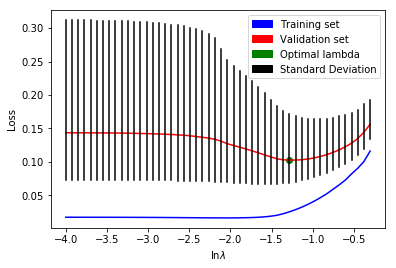

In [47]:
#plot
plt.plot(np.log10(avgbestlambda), avgvalidationlosses[int(avglowestlossind)], marker='o', markersize=6, color="green")
plt.plot(np.log10(lambdas), besttrainlosses , 'b')
plt.plot(np.log10(lambdas), avgvalidationlosses , 'r')
for ind in range(len(lambdas)):
	plt.plot([np.log10(lambdas[ind]), np.log10(lambdas[ind])], [minvalidationlosses[ind] , maxvalidationlosses[ind]] , 'black')
blue_patch = mpatches.Patch(color='blue', label='Training set')
red_patch = mpatches.Patch(color='red', label='Validation set')
green_patch = mpatches.Patch(color='green', label='Optimal lambda')
black_patch = mpatches.Patch(color='black', label='Standard Deviation')
plt.legend(handles=[blue_patch, red_patch, green_patch, black_patch])
plt.ylabel('Loss')
plt.xlabel('ln$\lambda$')
plt.show()

In [48]:
#Training

xtrain = tfs_train
ytrain = Ytrain
bestlambda = avgbestlambda #Select best lambda

cvweights = np.zeros((xtrain.shape[1],1)) #initialize to zero the weight vector that gets updated with iterations
gradient = np.ones((1,xtrain.shape[1])) #precision and maximum iterations (to avoid infinite loop)
iters, diff = 1, 1
gradientprev = 1000000;
while ((diff > 0.0025) and iters < 5000):#precision could be changed
	gradient = np.zeros((1,xtrain.shape[1]))
	iters += 1
	gradient = np.transpose((sigmoid((xtrain*cvweights))-ytrain)) * xtrain #compute gradient
	diff = (np.linalg.norm(gradient,ord = 1)-gradientprev)/(-gradientprev) #compute difference
	gradientprev = np.linalg.norm(gradient,ord = 1) #save gradient
	cvweights = cvweights - (2.25*(iters**(-0.9)))*(np.transpose(gradient) + bestlambda*cvweights) #update weights
print("final weights using entire training set:", cvweights)

final weights using entire training set: [[ 1.69688606]
 [ 2.53393251]
 [ 0.        ]
 ..., 
 [-1.81126487]
 [-0.10200149]
 [ 0.        ]]


In [50]:
#testing
weights = np.array(cvweights) #Select optimal weigths
testx = tfs_test
Ytest = Ytest
yhat = sigmoid((testx*weights)) #Estimation
success = 0
yhatround, yhatspam, yhatham, yhatspamind, yhathamind = [], [], [], [], []

for i in range(len(yhat)):
	if yhat[i] > 0.5: 
		yhatround.append(1) #Round up to 1
		if Ytest[i] == 1:
			yhatspam.append(yhat[i])
			yhatspamind.append(i)
			success = success + 1
		else:
			yhatham.append(yhat[i])
			yhathamind.append(i)
	else: 
		yhatround.append(0) #Round down to 0
		if Ytest[i] == 0:
			yhatham.append(yhat[i])
			yhathamind.append(i)
			success = success + 1
		else:
			yhatspam.append(yhat[i])
			yhatspamind.append(i)

success = success/Ytest.shape[0]
print("results on test data:")
print("Success: ", 100*success, "%")
print("Failure: ", 100*(1-success), "%")
lossvalidation = ((np.transpose(Ytest)*(-testx*weights))+np.sum((np.log(1+np.exp(testx*weights)))))/Ytest.shape[0] #Loss

results on test data:
Success:  97.70517308440296 %
Failure:  2.294826915597048 %


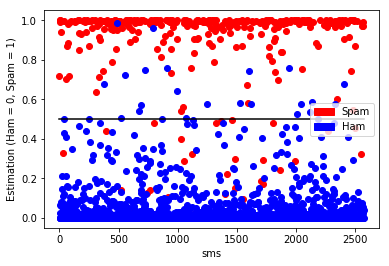

In [27]:
#Plot
plt.plot(yhatspamind,yhatspam, 'ro')
plt.plot(yhathamind,yhatham, 'bo')
plt.plot([0, len(yhat)], [0.5 , 0.5] , 'black')
red_patch = mpatches.Patch(color='red', label='Spam')
blue_patch = mpatches.Patch(color='blue', label='Ham')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel('Estimation (Ham = 0, Spam = 1)')
plt.xlabel('sms')
plt.show()	